In [1]:
%load_ext cython

Essential syntax:

In [3]:
%%cython

# python-level import
import numpy as np

# bring C level symbols to the namespace
cimport numpy as cnp

# Example: apply a C function elementwise

In [2]:
%load_ext cython

In [3]:
%%cython

cimport cython
import numpy as np


# Use the C standard library 
cdef extern from "math.h":
    double sin(double x) nogil


@cython.boundscheck(False)
@cython.wraparound(False)
cdef void _compute_sine(double[:] a,           # typed memoryview syntax
                        double[::1] out) nogil:
    cdef Py_ssize_t j
    for j in range(a.shape[0]):
        out[j] = sin(a[j])


def sine(a):
    """Compute sin(a), elementwise."""
    a = np.asarray(a)
    
    # Store the shape and flatten the array
    a_shape = a.shape
    a = a.ravel()
    
    # allocate the output arrays in python (refcounting!)
    cdef double[::1] out = np.empty_like(a)
    
    # do the work
    _compute_sine(a, out)
    
    # wrap the result in a numpy array
    return np.asarray(out).reshape(a_shape)

In [4]:
import numpy as np

In [5]:
a = np.random.random(size=20).reshape(2, 5, 2)

In [6]:
res = sine(a)

In [7]:
res.shape

(2, 5, 2)

In [8]:
np.allclose(res, np.sin(a))

True

## Typed memoryview of a C array


In [37]:
%%cython

cimport cython
import numpy as np

cdef extern from "math.h":
    double sin(double x) nogil
    double M_PI


# Same _compute_sine as above

@cython.boundscheck(False)
@cython.wraparound(False)
cdef void _compute_sine(double[:] a,           # typed memoryview syntax
                        double[::1] out) nogil:
    cdef Py_ssize_t j
    for j in range(a.shape[0]):
        out[j] = sin(a[j])
        

def c_sine():
    """Create a C array, make a typed memoryview on it, and compute sines."""
    cdef double arr[8]
    
    for j in range(8):
        arr[j] = (j + 0.5) * M_PI
        
    cdef double[::1] view = arr
    cdef double[::1] out = np.empty(8, dtype=float)
    _compute_sine(view, out)
    
    ###### BIG FAT WARNING: `copy=True`, to avoid a dangling pointer. 
    return np.array(out, copy=True)

In [40]:
a = c_sine()
a

array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.])

In [39]:
a.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

**Best allocate memory on the Python side.** Otherwise, tie the lifetime of pointers to some python objects. (E.g., declare a `cdef class Holder` to store the pointer, or --- better --- allocate and deallocate memory in constructor and destructor)

# Solve a Laplace equation, $\nabla^2 u = 0$

For simplicity, use some hard-coded boundary conditions.

Travis Oliphant, http://technicaldiscovery.blogspot.ru/2011/06/speeding-up-python-numpy-cython-and.html

In [9]:
dx = 0.1
dy = 0.1
dx2 = dx*dx
dy2 = dy*dy

def py_update(u, dx2, xy2):
    nx, ny = u.shape
    for i in range(1,nx-1):
        for j in range(1, ny-1):
            u[i,j] = ((u[i+1, j] + u[i-1, j]) * dy2 +
                      (u[i, j+1] + u[i, j-1]) * dx2) / (2*(dx2+dy2))

            
def calc(N, n_iter=100, func=py_update):
    # set up the boundary condition
    u = np.zeros((N, N), dtype=float)
    u[0] = 1
    
    # loop
    for i in range(n_iter):
        func(u, dx2, dy2)
        
    return np.asarray(u)

In [10]:
u = calc(10, n_iter=1000)

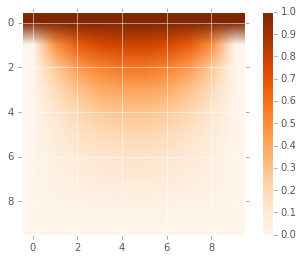

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.imshow(u, cmap=plt.cm.Oranges)
plt.colorbar()

In [12]:
%timeit calc(50, n_iter=1000)

1 loop, best of 3: 4.27 s per loop


Move the update loop to Cython

In [13]:
%%cython -a --compile-args=-O3

cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def cy_update(double[:, ::1] u, double dx2, double dy2):
    cdef Py_ssize_t i, j
    for i in range(1, u.shape[0]-1):
        for j in range(1, u.shape[1]-1):
            u[i, j] = ((u[i+1, j] + u[i-1, j]) * dy2 +
                       (u[i, j+1] + u[i, j-1]) * dx2) / (2*(dx2+dy2))

In [14]:
u = calc(100, n_iter=8000, func=cy_update)

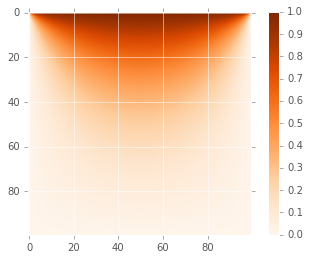

In [15]:
plt.imshow(u, cmap=plt.cm.Oranges)
plt.colorbar()

In [16]:
%timeit calc(50, n_iter=1000, func=cy_update)

10 loops, best of 3: 26.5 ms per loop


# Practice exercises

1. Separate the boundary conditions from the `calc` function above. It should accept a preallocated array `u`.

2. Modify the ODE solver for `Planet` to output the trajectory as a numpy array.

3. Write a Cython function for a nearest-neighbor average of a 2D numpy array.

4. Find all solutions of the equation $x = a \, \sin{x}$. *Hint:* cythonize the bisection root-finding algorithm, and use it on each $2\pi$ interval.